In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import haversine_distances

In order to avoid crashing the kernel, only read a portion of the data

In [2]:
df = pd.read_csv('train.csv', nrows = 1_000_000)
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In order to determine the amount of distance traveled, use the Haversine formula

Note, I didn't use Euclidean distance because the coordinates are points on a sphere. 

In [3]:
def hav_distance(lon1, lat1, lon2, lat2):
    # use sklearn's haversine function and multiply by Earth's radius to get distance in km
    return haversine_distances([[lon1, lat1], [lon2, lat2]])[0][1] * 6371000/1000

# create new feature using this function, distance in km
df['distance_traveled_km'] = df.apply(lambda x: hav_distance(x['pickup_longitude'], x['pickup_latitude'], 
                                                             x['dropoff_longitude'], x['dropoff_latitude']), axis=1)

To clean the data, drop any NaNs from the df

In [4]:
df = df.dropna(axis='rows')
print('New number of observations: %d' % len(df))

New number of observations: 999990


Find distribution of the distance traveled

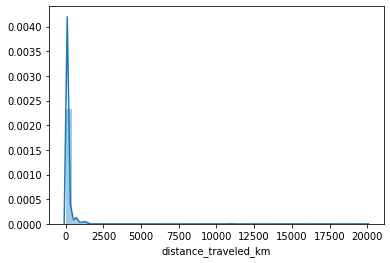

In [5]:
sns.distplot(df['distance_traveled_km'])

In [6]:
df['distance_traveled_km'].quantile(.99)

1265.7037110087654

Some of the observations are too high to make sense, so take out all of the rows where the distance traveled is above the 95th percentile

In [7]:
df = df[df['distance_traveled_km'] <= df['distance_traveled_km'].quantile(.95)]
df['distance_traveled_km'].describe()

count    949990.000000
mean        104.494342
std          96.599768
min           0.000000
25%          39.341702
50%          77.308638
75%         138.641660
max         621.220036
Name: distance_traveled_km, dtype: float64

New distribution after the filtering

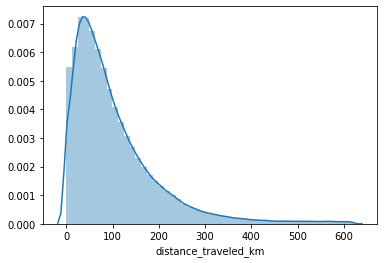

In [8]:
sns.distplot(df['distance_traveled_km'])

In [12]:
df_zero = df[df['distance_traveled_km'] == 0]

len(df_zero)

28478

There are apparently over 28 k rows where there was no distance traveled, should probably take those out too

In [15]:
df = df[df['distance_traveled_km'] > 0]

Some of the fares also make no sense, so fix that too

In [30]:
df['fare_amount'].describe()

count    921456.000000
mean          9.815651
std           6.358627
min           0.010000
25%           6.000000
50%           8.100000
75%          11.700000
max         450.000000
Name: fare_amount, dtype: float64

In [32]:
df['fare_amount'].quantile(.999)

57.33

If the 99.9th percentile is less than 60, it looks safe to just cut out values > 75

In [37]:
df = df[df['fare_amount'] < 75]
df['fare_amount'].describe()

count    911905.000000
mean          9.460761
std           5.026711
min           0.010000
25%           6.000000
50%           8.100000
75%          11.500000
max          31.900000
Name: fare_amount, dtype: float64

Text(0.5, 1.0, 'Histogram')

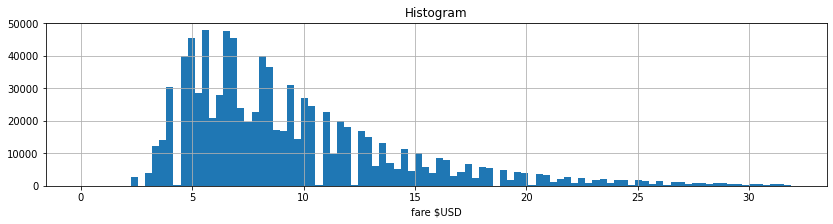

In [39]:
df.fare_amount.hist(bins=100, figsize=(14,3))
plt.xlabel('fare $USD')
plt.title('Histogram')

In [25]:
df['fare_amount'].describe()

count    921456.000000
mean          9.815651
std           6.358627
min           0.010000
25%           6.000000
50%           8.100000
75%          11.700000
max         450.000000
Name: fare_amount, dtype: float64

In [41]:
df_fare = df[df['fare_amount'] < df['fare_amount'].quantile(.99)]
df_fare.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_traveled_km
count,902520.000000,902520.000000,902520.000000,902520.000000,902520.000000,902520.000000,902520.000000
mean,9.256788,-73.916915,40.694017,-73.916506,40.692234,1.681792,103.572122
std,4.633223,2.641424,2.717616,2.821408,2.575068,1.306070,88.567493
min,0.010000,-121.391210,-74.016587,-740.066667,-74.016627,0.000000,0.000214
25%,5.900000,-73.992607,40.737147,-73.991840,40.736770,1.000000,42.023986
50%,8.000000,-73.982450,40.753323,-73.981205,40.753975,1.000000,78.692116
75%,11.500000,-73.970150,40.767021,-73.967578,40.768187,2.000000,137.769272
max,26.990000,40.812887,424.083332,40.825310,45.035269,6.000000,621.220036


Since as of 2018, the lowest base fee for a taxi ride in NYC is $2.50, I'll drop observations with fare_amount below 1.5

In [42]:
df = df[df['fare_amount'] > 1.5]
df['fare_amount'].describe()

count    911898.000000
mean          9.460834
std           5.026662
min           2.500000
25%           6.000000
50%           8.100000
75%          11.500000
max          31.900000
Name: fare_amount, dtype: float64

In [45]:
df['passenger_count'].describe()

count    911898.000000
mean          1.682120
std           1.306322
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           6.000000
Name: passenger_count, dtype: float64

Basically what I'm thinking at this point is to first figure out what other values don't make sense and take them out of the data. Then I want to convert the pickup_datetime into a useable timestamp. Finally, I think it could be helpful to build a multiple linear regression using the distance_traveled, passenger_count, and time of day based on the time stamp

In [28]:
df['distance_traveled_km'].describe()

count    921456.000000
mean        107.728141
std          96.290639
min           0.000214
25%          42.443099
50%          80.014014
75%         141.372361
max         621.220036
Name: distance_traveled_km, dtype: float64